Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation¶

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the Oxford Flower 102 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by Oxford Flower 102, which consists of 102 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the Oxford Flower 102 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of Oxford Flower 102.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the Oxford Flower 102 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on Oxford Flower 102.

## 1. Data Loading and Preprocessing
Load the Oxford Flower 102 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
!pip install tensorflow-datasets


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [3]:
# Number of images in the datasets ? 

print("train - ", info.splits['train'].num_examples)
print("validation - ", info.splits['validation'].num_examples)
print("train - ", info.splits['test'].num_examples)

train -  1020
validation -  1020
train -  6149


#### Their is huge data imbalance hence we will be adding train and val datasets 

In [4]:
train_dataset = dataset['train'].concatenate(dataset['validation'])

In [5]:
print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

2040
6149


### Checking the size of images in the dataset 

In [6]:
# take one sample from the training dataset 

for image, label in train_dataset.take(4):
    print("Image shape: ", image.shape)
    print("Label: ", label)

Image shape:  (500, 667, 3)
Label:  tf.Tensor(72, shape=(), dtype=int64)
Image shape:  (500, 666, 3)
Label:  tf.Tensor(84, shape=(), dtype=int64)
Image shape:  (670, 500, 3)
Label:  tf.Tensor(70, shape=(), dtype=int64)
Image shape:  (500, 505, 3)
Label:  tf.Tensor(51, shape=(), dtype=int64)


### Lets see a image from the dataset 

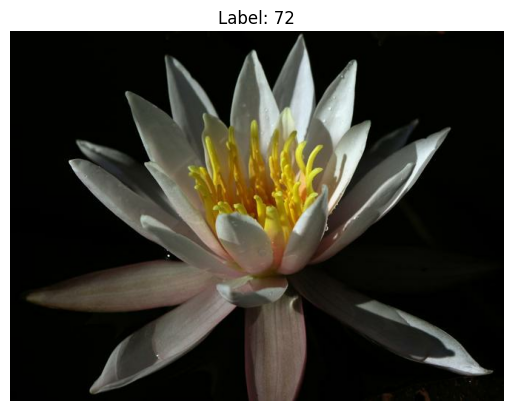

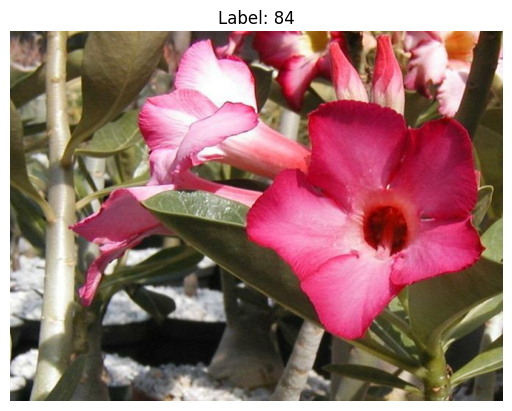

In [7]:
import matplotlib.pyplot as plt

for image, label in train_dataset.take(2):
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()


In [8]:
IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    return image, label

train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [9]:
for image, label in train_dataset.take(4):
    print("Image shape: ", image.shape)
    print("Label: ", label)

Image shape:  (224, 224, 3)
Label:  tf.Tensor(72, shape=(), dtype=int64)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(84, shape=(), dtype=int64)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(70, shape=(), dtype=int64)
Image shape:  (224, 224, 3)
Label:  tf.Tensor(51, shape=(), dtype=int64)


In [10]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2

def prep_resnet(image, label):
    return preprocess_resnet50(image), label

def prep_vgg(image, label):
    return preprocess_vgg16(image), label

def prep_mobilenet(image, label):
    return preprocess_mobilenetv2(image), label


train_resnet = train_dataset.map(prep_resnet)
test_resnet = test_dataset.map(prep_resnet)

train_vgg = train_dataset.map(prep_vgg)
test_vgg = test_dataset.map(prep_vgg)

train_mobilenet = train_dataset.map(prep_mobilenet)
test_mobilenet = test_dataset.map(prep_mobilenet)


In [27]:
test_vgg = test_dataset.map(prep_vgg)

In [11]:
for image, label in train_dataset.take(4):
    print("Image Shape : ", image.shape," ", label)

Image Shape :  (224, 224, 3)   tf.Tensor(72, shape=(), dtype=int64)
Image Shape :  (224, 224, 3)   tf.Tensor(84, shape=(), dtype=int64)
Image Shape :  (224, 224, 3)   tf.Tensor(70, shape=(), dtype=int64)
Image Shape :  (224, 224, 3)   tf.Tensor(51, shape=(), dtype=int64)


In [12]:
print(tf.data.experimental.cardinality(test_dataset).numpy())
print(tf.data.experimental.cardinality(train_dataset).numpy())

6149
2040


In [13]:
def configure_for_performance(ds, batch_size=32):
    ds = ds.cache() # Keep data in memory after first epoch (if it fits)
    ds = ds.shuffle(buffer_size=1000) # Only shuffle training data usually
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Apply to all your new datasets
train_resnet = configure_for_performance(train_resnet)
test_resnet = configure_for_performance(test_resnet)
train_vgg = configure_for_performance(train_vgg)
# ... do the same for others

### 2.1 Using ResNet50

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 1. Fresh Base (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Add Your Head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model_warmup = Model(inputs=base_model.input, outputs=predictions)

print("--- PHASE 1: WARMUP (Head Only) ---")

# 1. Freeze EVERYTHING in the base model
base_model.trainable = False 

# 2. Compile with STANDARD Learning Rate
model_warmup.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# 3. Train for a few epochs (e.g., 5 is usually enough to stabilize)
history_phase1 = model_warmup.fit(train_resnet, 
                                  validation_data=test_resnet, 
                                  epochs=5)

--- PHASE 1: WARMUP (Head Only) ---
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.4941 - loss: 2.3820 - val_accuracy: 0.7452 - val_loss: 1.0133
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.9255 - loss: 0.3106 - val_accuracy: 0.7886 - val_loss: 0.8586
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.9775 - loss: 0.1117 - val_accuracy: 0.8341 - val_loss: 0.6252
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9936 - loss: 0.0475 - val_accuracy: 0.8484 - val_loss: 0.5692
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9985 - loss: 0.0173 - val_accuracy: 0.8748 - val_loss: 0.4894


In [16]:
model_warmup.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 30,195,892 (115.19 MB)

 Trainable params: 2,202,726 (8.40 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,405,454 (16.81 MB)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model_warmup.compile(optimizer=Adam(learning_rate=1e-5), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])
checkpoint_resnet = ModelCheckpoint('best_resnet_oxford.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_warmup.fit(train_resnet, 
                validation_data=test_resnet, 
                epochs=2, 
                callbacks = [checkpoint_resnet])


Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8967 - loss: 0.3588
Epoch 1: val_accuracy improved from None to 0.87900, saving model to best_resnet_oxford.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.9240 - loss: 0.2736 - val_accuracy: 0.8790 - val_loss: 0.4833
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.9980 - loss: 0.0526
Epoch 2: val_accuracy did not improve from 0.87900
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9975 - loss: 0.0516 - val_accuracy: 0.8725 - val_loss: 0.5184


In [21]:
history_resnet = model_warmup.fit(train_resnet, 
                                    validation_data=test_resnet, 
                                    epochs=2, 
                                    callbacks = [checkpoint_resnet])

Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.9997 - loss: 0.0271
Epoch 1: val_accuracy did not improve from 0.87900
64/64 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9990 - loss: 0.0266 - val_accuracy: 0.8650 - val_loss: 0.5495
Epoch 2/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.9997 - loss: 0.0180
Epoch 2: val_accuracy did not improve from 0.87900
64/64 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.9995 - loss: 0.0176 - val_accuracy: 0.8623 - val_loss: 0.5591


### 2.2 Using VGG16

In [20]:
from tensorflow.keras.applications import VGG16

train_vgg_ds = train_dataset.map(prep_vgg).batch(32).prefetch(tf.data.AUTOTUNE)
test_vgg_ds = test_dataset.map(prep_vgg).batch(32).prefetch(tf.data.AUTOTUNE)

# --- STEP 2: BUILD MODEL ---
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_vgg.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model_vgg = Model(inputs=base_vgg.input, outputs=predictions)

# --- STEP 3: PHASE 1 - WARMUP (Head Only) ---
print("\n--- VGG16 PHASE 1: WARMUP ---")
base_vgg.trainable = False  # Freeze Base

model_vgg.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

model_vgg.fit(train_vgg_ds, validation_data=test_vgg_ds, epochs=5)

# --- STEP 4: PHASE 2 - FINE TUNING ---
print("\n--- VGG16 PHASE 2: FINE TUNING ---")
base_vgg.trainable = True

# VGG is shallow: Freeze everything except the last 4 layers (Block 5)
for layer in base_vgg.layers[:-4]:
    layer.trainable = False

# Compile with LOW Learning Rate
model_vgg.compile(optimizer=Adam(learning_rate=1e-5), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

# Save the best model
checkpoint_vgg = ModelCheckpoint('best_vgg_oxford.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model_vgg.fit(train_vgg_ds, 
              validation_data=test_vgg_ds, 
              epochs=10, 
              callbacks=[checkpoint_vgg])


--- VGG16 PHASE 1: WARMUP ---
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 405s 6s/step - accuracy: 0.3980 - loss: 3.3246 - val_accuracy: 0.6167 - val_loss: 1.5896
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 403s 6s/step - accuracy: 0.8907 - loss: 0.4618 - val_accuracy: 0.7110 - val_loss: 1.1288
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 404s 6s/step - accuracy: 0.9750 - loss: 0.1385 - val_accuracy: 0.7687 - val_loss: 0.8930
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 409s 6s/step - accuracy: 0.9931 - loss: 0.0528 - val_accuracy: 0.7938 - val_loss: 0.8168
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 410s 6s/step - accuracy: 0.9995 - loss: 0.0216 - val_accuracy: 0.8045 - val_loss: 0.7555

--- VGG16 PHASE 2: FINE TUNING ---
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0055
Epoch 1: val_accuracy improved from None to 0.82355, saving model to best_vgg_oxford.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 421s 7s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8235 - val_loss: 0.8264
Epoch 2/10
64

In [22]:
history_vgg = model_vgg.fit(train_vgg_ds, 
                          validation_data=test_vgg_ds, 
                          epochs=10, 
                          callbacks=[checkpoint_vgg])

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.1878e-05
Epoch 1: val_accuracy improved from 0.83428 to 0.83444, saving model to best_vgg_oxford.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 396s 6s/step - accuracy: 1.0000 - loss: 2.1746e-05 - val_accuracy: 0.8344 - val_loss: 0.9125
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.9047e-05
Epoch 2: val_accuracy improved from 0.83444 to 0.83461, saving model to best_vgg_oxford.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 396s 6s/step - accuracy: 1.0000 - loss: 1.8928e-05 - val_accuracy: 0.8346 - val_loss: 0.9183
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.6739e-05
Epoch 3: val_accuracy improved from 0.83461 to 0.83510, saving model to best_vgg_oxford.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 395s 6s/step - accuracy: 1.0000 - loss: 1.6631e-05 - val_accuracy: 0.8351 - val_loss: 0.9237
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.4812e-05
Epoch 4: v

### 2.3 Using MobileNetV2

In [23]:
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pp

# --- STEP 1: SPECIFIC DATA PIPELINE ---
def prep_mobilenet(image, label):
    return mobilenet_pp(image), label

# Create MobileNet specific datasets
train_mobile_ds = train_dataset.map(prep_mobilenet).batch(32).prefetch(tf.data.AUTOTUNE)
test_mobile_ds = test_dataset.map(prep_mobilenet).batch(32).prefetch(tf.data.AUTOTUNE)

# --- STEP 2: BUILD MODEL ---
base_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_mobile.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(102, activation='softmax')(x)

model_mobile = Model(inputs=base_mobile.input, outputs=predictions)

# --- STEP 3: PHASE 1 - WARMUP (Head Only) ---
print("\n--- MOBILENET PHASE 1: WARMUP ---")
base_mobile.trainable = False # Freeze Base

model_mobile.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

model_mobile.fit(train_mobile_ds, validation_data=test_mobile_ds, epochs=5)

# --- STEP 4: PHASE 2 - FINE TUNING ---
print("\n--- MOBILENET PHASE 2: FINE TUNING ---")
base_mobile.trainable = True

# MobileNet is deep: Freeze all except last 40 layers
for layer in base_mobile.layers[:-40]:
    layer.trainable = False

# Compile with LOW Learning Rate
model_mobile.compile(optimizer=Adam(learning_rate=1e-5), 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Save the best model
checkpoint_mobile = ModelCheckpoint('best_mobilenet_oxford.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history_mobilenet = model_mobile.fit(train_mobile_ds, 
                                     validation_data=test_mobile_ds, 
                                     epochs=5, 
                                     callbacks=[checkpoint_mobile])


--- MOBILENET PHASE 1: WARMUP ---
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 937ms/step - accuracy: 0.4417 - loss: 2.6382 - val_accuracy: 0.6302 - val_loss: 1.5908
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 922ms/step - accuracy: 0.8730 - loss: 0.5238 - val_accuracy: 0.7481 - val_loss: 0.9677
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 922ms/step - accuracy: 0.9588 - loss: 0.1993 - val_accuracy: 0.7796 - val_loss: 0.8177
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9941 - loss: 0.0734 - val_accuracy: 0.8084 - val_loss: 0.6956
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 924ms/step - accuracy: 0.9980 - loss: 0.0358 - val_accuracy: 0.8248 - val_loss: 0.6223

--- MOBILENET PHASE 2: FINE TUNING ---
Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5574 - loss: 1.7292
Epoch 1: val_accuracy improved from None to 0.82810, saving model to best_mobilenet_oxford.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6196 - loss: 1.4462 - val_accuracy: 0.8281 - val_los

## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [31]:
acc_resnet50    = model_warmup.evaluate(test_resnet)[1]
acc_vgg16       = model_vgg.evaluate(test_vgg_ds)[1]
acc_mobilenetv2 = model_mobile.evaluate(test_mobile_ds)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

193/193 ━━━━━━━━━━━━━━━━━━━━ 126s 653ms/step - accuracy: 0.8623 - loss: 0.5591
193/193 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - accuracy: 0.8357 - loss: 0.9559
193/193 ━━━━━━━━━━━━━━━━━━━━ 45s 233ms/step - accuracy: 0.8314 - loss: 0.6255
ResNet50 Accuracy: 0.86
VGG16 Accuracy: 0.84
MobileNetV2 Accuracy: 0.83


### Plot 

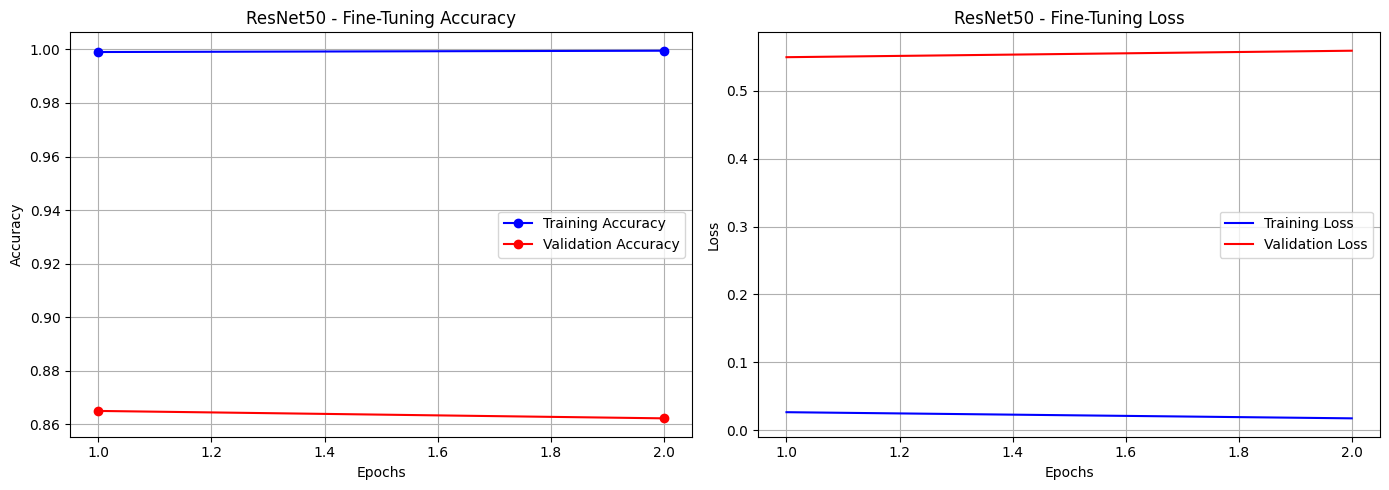

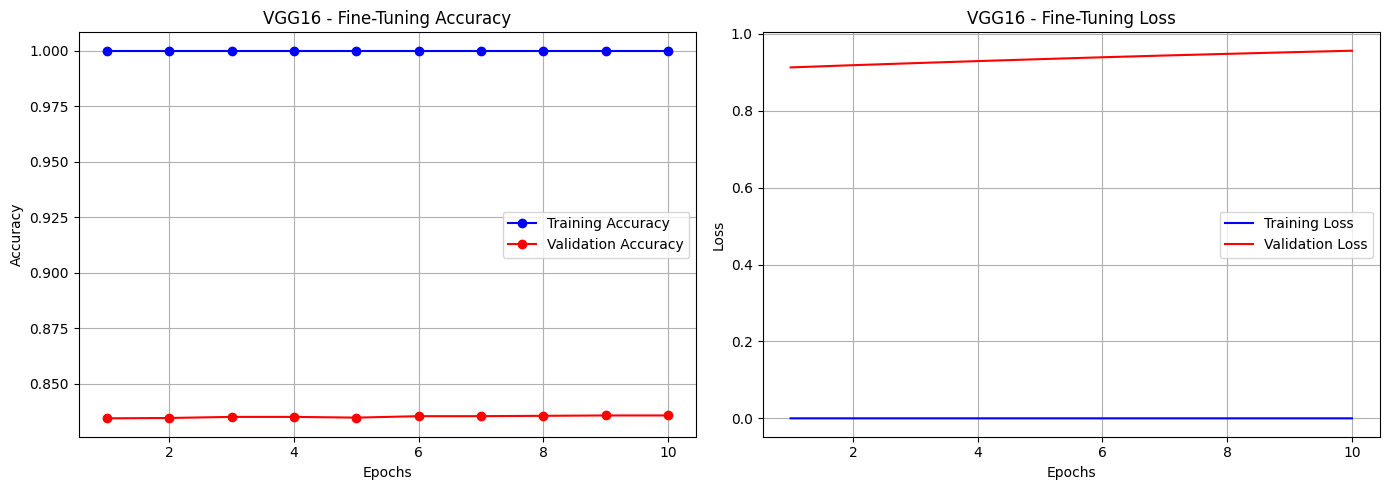

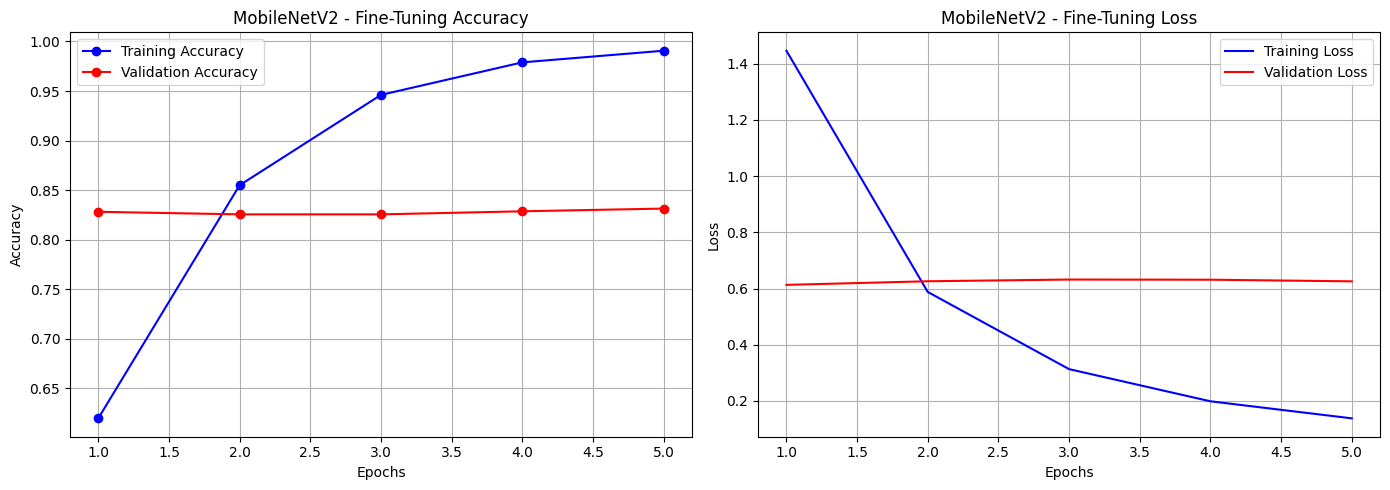

In [33]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    # Check if history exists (in case the variable is None)
    if history is None:
        print(f"No history found for {model_name}. Did you assign 'history = model.fit(...)'?")
        return

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Fine-Tuning Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Fine-Tuning Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- PLOT YOUR MODELS ---

# 1. ResNet50 (We used 'history_phase2' in the 2-stage code)
# If you overwrote it or used a different name, swap it here.
plot_history(history_resnet, 'ResNet50') 

# 2. VGG16 (Ensure you assigned history_vgg = model.fit(...))
plot_history(history_vgg, 'VGG16')

# 3. MobileNetV2 (Ensure you assigned history_mobile = model.fit(...))
plot_history(history_mobilenet, 'MobileNetV2')

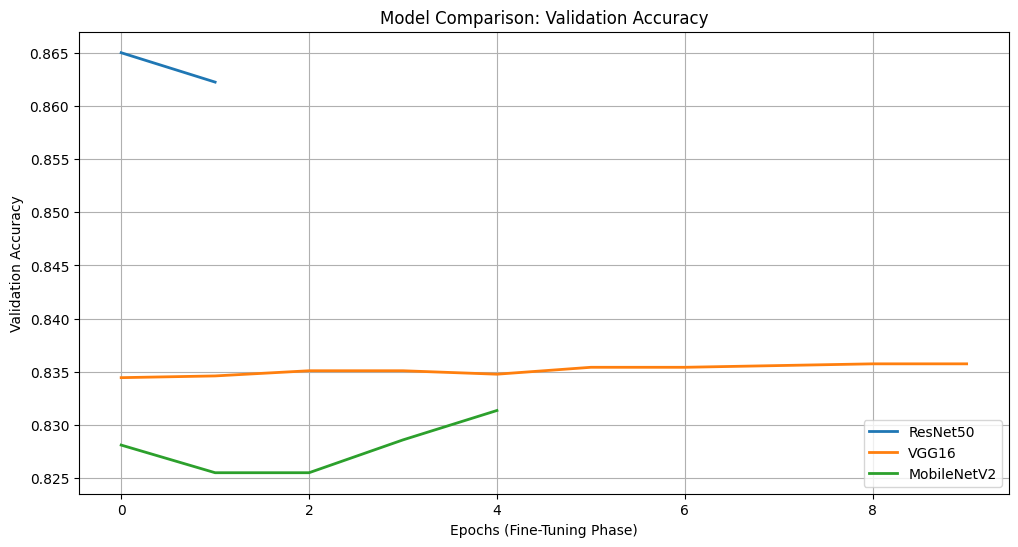

In [35]:
def plot_comparison(histories, names):
    plt.figure(figsize=(12, 6))
    
    # Iterate through all histories and plot their Validation Accuracy
    for history, name in zip(histories, names):
        if history is not None:
            plt.plot(history.history['val_accuracy'], linestyle='-', linewidth=2, label=name)
        
    plt.title('Model Comparison: Validation Accuracy')
    plt.xlabel('Epochs (Fine-Tuning Phase)')
    plt.ylabel('Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Run the comparison
plot_comparison(
    [history_resnet, history_vgg, history_mobilenet], 
    ['ResNet50', 'VGG16', 'MobileNetV2']
)

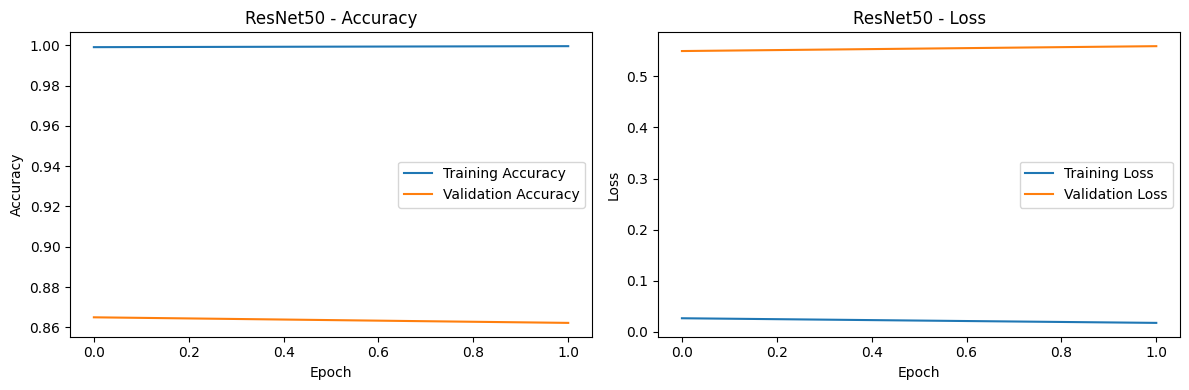

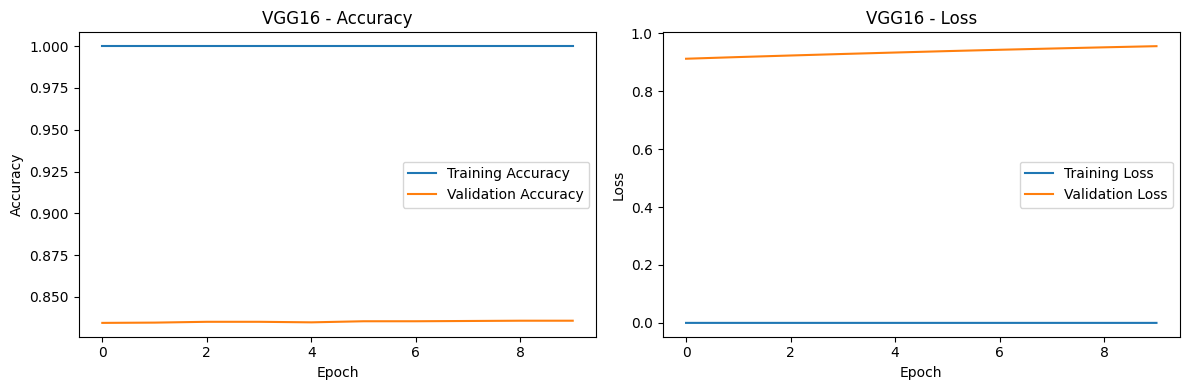

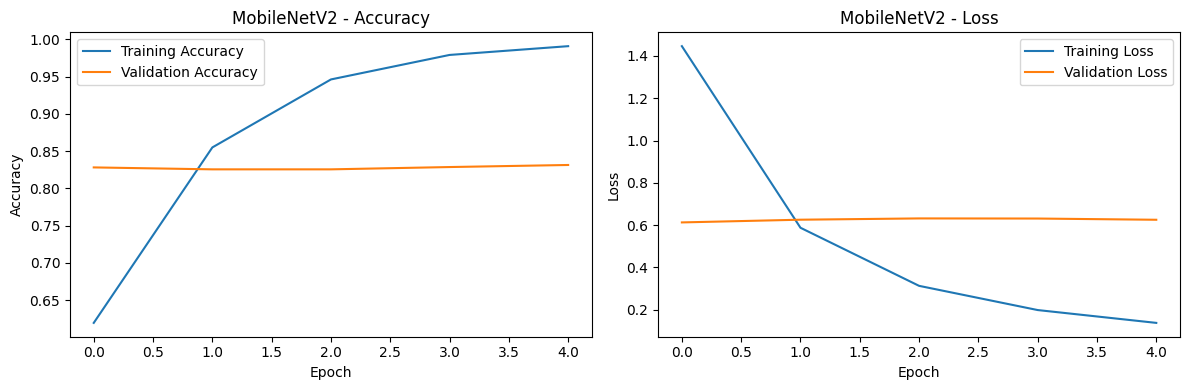

In [36]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet, 'ResNet50')
plot_history(history_vgg, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')

In [37]:
print(tf.data.experimental.cardinality(train_dataset).numpy())


2040


In [49]:
!pip install requests


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Predicting single images

Success! Image saved to R:\AI-ML-Portfolio\AI-ML-Portfolio\Project_9\flower_test1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


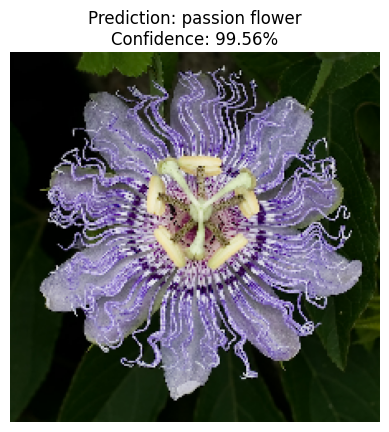

'passion flower'

In [64]:
import requests
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pp
import matplotlib.pyplot as plt

# 1. Get the list of Flower Names
# We use the 'info' object you downloaded at the very beginning
class_names = info.features['label'].names

def predict_single_image(model, image_path):
    # --- A. Load and Resize ---
    # We must force the image to 224x224 to match the model input
    img = load_img(image_path, target_size=(224, 224))
    
    # --- B. Convert to Array & Batch ---
    # Convert image to numpy array (224, 224, 3)
    img_array = img_to_array(img)
    
    # Add the "Batch Dimension" (1, 224, 224, 3)
    # The model expects a stack of images, even if it's just one.
    img_batch = np.expand_dims(img_array, axis=0)
    
    # --- C. Preprocess ---
    # CRITICAL: We must use the specific preprocessing for ResNet50
    # (This centers the pixels and converts RGB to BGR)
    img_preprocessed = resnet_pp(img_batch)
    
    # --- D. Predict ---
    predictions = model.predict(img_preprocessed)
    
    # --- E. Interpret Results ---
    # Get the index with the highest probability
    score = tf.nn.softmax(predictions[0]) # Optional: makes scores easier to read
    predicted_class_index = np.argmax(predictions)
    predicted_flower_name = class_names[predicted_class_index]
    confidence = np.max(predictions) * 100
    
    # --- F. Display ---
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_flower_name}\nConfidence: {confidence:.2f}%")
    plt.show()
    
    return predicted_flower_name

# --- TEST IT ---import requests
import os

def download_with_browser_headers(url, save_name):
    # This header pretends you are a browser to bypass the 403 Block
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        # Save the file locally
        with open(save_name, 'wb') as f:
            f.write(response.content)
        print(f"Success! Image saved to {os.path.abspath(save_name)}")
        return save_name
    else:
        raise Exception(f"Failed to download. Status: {response.status_code}")

# --- USE IT ---
image_url = "https://upload.wikimedia.org/wikipedia/commons/e/e5/OQ_Passion_flower.jpg"

# Download the file safely
image_path = download_with_browser_headers(image_url, 'flower_test1.jpg')

# Run the prediction
predict_single_image(model_warmup, image_path)

In [43]:
# 1. Get the list of names from the metadata
# The index in this list corresponds to the Label ID (0, 1, 2...)
flower_names = info.features['label'].names

# 2. Print a specific label (e.g., checking what Label 70 is)
print(f"Label 70 is: {flower_names[70]}")

# 3. Print the first 10 pairings to see how they look
print("\n--- First 10 Labels ---")
for i in range(10):
    print(f"ID {i}: {flower_names[i]}")

# 4. (Optional) Create a dictionary for easy lookup later
label_map = {i: name for i, name in enumerate(flower_names)}

Label 70 is: gazania

--- First 10 Labels ---
ID 0: pink primrose
ID 1: hard-leaved pocket orchid
ID 2: canterbury bells
ID 3: sweet pea
ID 4: english marigold
ID 5: tiger lily
ID 6: moon orchid
ID 7: bird of paradise
ID 8: monkshood
ID 9: globe thistle
